# Understanding Gender Differences in Tweets with Deep Learning 

***

## Summer Chambers (ssc4mc), Keyu Chen (km5ar), Hannah Frederick (hbf3k)  

The .csv file that we read in can be found here: https://www.kaggle.com/crowdflower/twitter-user-gender-classification

The code that we source from can be found here: https://www.kaggle.com/gcdatkin/deep-recurrent-nn-for-gender-classification#Data-Every-Day

# Importing Data

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import bert
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pydot
import graphviz
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
data = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1')

In [ ]:
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,...,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,...,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,...,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,...,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN


In [ ]:
data[["text", "gender"]]

,text,gender
0,Robbie E Responds To Critics After Win Against...,male
1,ÛÏIt felt like they were my friends and I was...,male
2,i absolutely adore when louis starts the songs...,male
3,Hi @JordanSpieth - Looking at the url - do you...,male
4,Watching Neighbours on Sky+ catching up with t...,female
...,...,...
20045,"@lookupondeath ...Fine, and I'll drink tea too...",female
20046,Greg Hardy you a good player and all but don't...,male
20047,You can miss people and still never want to se...,male
20048,@bitemyapp i had noticed your tendency to pee ...,female


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

# Preprocessing

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop unnecessary columns
    df = df[['gender','text', 'description']]
    
    # Encode unknown values in the target column as np.NaN
    df['gender'] = df['gender'].replace('unknown', np.NaN)
    
    # Drop rows with missing target values
    gender_nas = df[df['gender'].isna()].index
    df = df.drop(gender_nas, axis=0).reset_index(drop=True)

    # Drop rows with "brand" target values
    gender_brand = df[df['gender'] == 'brand'].index
    df = df.drop(gender_brand, axis=0).reset_index(drop=True)
    
    # Get sequence data for text column
    tweets = [str(text)+' '+str(desc) for text, desc in zip(df.text, df.description)]
    
    # Encode label column
    label_mapping = {'female': 0, 'male': 1}
    df['gender'] = df['gender'].replace(label_mapping)
    
    # Get target data from gender column
    y = df['gender'].copy()
    
    return tweets, y

In [ ]:
tweets, y = preprocess_inputs(data)

In [ ]:
tweets = np.asarray(tweets)
tweets.shape

(12894,)

In [ ]:
y.shape

(12894,)

In [ ]:
y.value_counts()

0    6700
1    6194
Name: gender, dtype: int64

In [ ]:
tweets

array(['Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ i sing my own rhythm.',
       "\x89ÛÏIt felt like they were my friends and I was living the story with them\x89Û\x9d https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz I'm the author of novels filled with family drama and romance.",
       'i absolutely adore when louis starts the songs it hits me hard but it feels good louis whining and squealing and all',
       ...,
       'You can miss people and still never want to see them again #TeamBarcelona ..You look lost so you should follow me!!! ...follow your heart but bring your brain with you..#Okbye',
       "@bitemyapp i had noticed your tendency to pee on the carpet, but i didn't want to say anything :P Anti-statist; I homeschool my kids. Aspiring thoughtleader in the field of disjunction. Obligate carnivore. Writing @haskellbook with @bitemyapp.",
       "I think for my APUSH creative project I'm going t

# Splitting Train/Test Sets

In [ ]:
tweets_train, tweets_test, y_train, y_test = train_test_split(tweets, y, train_size=0.8, random_state=1)

In [ ]:
y_train.value_counts()

0    5342
1    4973
Name: gender, dtype: int64

In [ ]:
y_test.value_counts()

0    1358
1    1221
Name: gender, dtype: int64

# Modeling

https://www.tensorflow.org/tutorials/text/classify_text_with_bert

In [ ]:
bert_model_name = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocessor_name = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
preprocess_bert = hub.KerasLayer(bert_preprocessor_name)
bert_model = hub.KerasLayer(bert_model_name)



In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocess_bert, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, metho

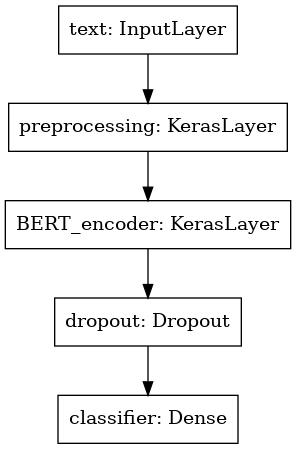

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 3
batch_size = 32
optimizer = 'adam'

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(tweets_train, y_train,
                            validation_split=0.2,
                            epochs=epochs, 
                            batch_size=batch_size,
                            callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./bert_model.h5', save_best_only=True, save_weights_only=True),
        tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/3
258/258 [==============================] - 1463s 6s/step - loss: 0.7055 - binary_accuracy: 0.5408 - val_loss: 0.6507 - val_binary_accuracy: 0.6258
Epoch 2/3
258/258 [==============================] - 2077s 8s/step - loss: 0.6625 - binary_accuracy: 0.6039 - val_loss: 0.6340 - val_binary_accuracy: 0.6437
Epoch 3/3
258/258 [==============================] - 1517s 6s/step - loss: 0.6446 - binary_accuracy: 0.6273 - val_loss: 0.6242 - val_binary_accuracy: 0.6520


In [ ]:
classifier_model.load_weights('./bert_model.h5')

In [ ]:
import h5py
def read_hdf5(path):

    weights = {}

    keys = []
    with h5py.File(path, 'r') as f: # open file
        f.visit(keys.append) # append all keys to list
        for key in keys:
            if ':' in key: # contains data if ':' in key
                print(f[key].name)
                weights[f[key].name] = f[key].value
    return weights

# https://stackoverflow.com/questions/51923048/what-is-the-difference-between-these-two-ways-of-saving-keras-machine-learning-m

In [ ]:
read_hdf5('bert_model.h5')

/BERT_encoder/Variable:0
/BERT_encoder/embeddings/layer_norm/beta:0
/BERT_encoder/embeddings/layer_norm/gamma:0
/BERT_encoder/pooler_transform/bias:0
/BERT_encoder/pooler_transform/kernel:0
/BERT_encoder/position_embedding/embeddings:0
/BERT_encoder/transformer/layer_0/intermediate/bias:0
/BERT_encoder/transformer/layer_0/intermediate/kernel:0
/BERT_encoder/transformer/layer_0/output/bias:0
/BERT_encoder/transformer/layer_0/output/kernel:0
/BERT_encoder/transformer/layer_0/output_layer_norm/beta:0
/BERT_encoder/transformer/layer_0/output_layer_norm/gamma:0
/BERT_encoder/transformer/layer_0/self_attention/attention_output/bias:0
/BERT_encoder/transformer/layer_0/self_attention/attention_output/kernel:0
/BERT_encoder/transformer/layer_0/self_attention/key/bias:0
/BERT_encoder/transformer/layer_0/self_attention/key/kernel:0
/BERT_encoder/transformer/layer_0/self_attention/query/bias:0
/BERT_encoder/transformer/layer_0/self_attention/query/kernel:0
/BERT_encoder/transformer/layer_0/self_at

{'/BERT_encoder/Variable:0': True,
 '/BERT_encoder/embeddings/layer_norm/beta:0': array([-7.50299469e-02,  3.05416677e-02, -3.88073213e-02,  7.60145411e-02,
         6.80232644e-02, -3.56679820e-02, -2.29676627e-02, -2.00715363e-02,
         4.69574891e-02, -8.68048668e-02, -2.96968222e-02, -2.83804853e-02,
         1.27371948e-03,  1.21920099e-02, -1.12013638e-01, -3.29227075e-02,
        -4.25835839e-03,  5.27247302e-02,  1.82300713e-03, -3.47767510e-02,
         3.05963811e-02, -5.18376306e-02,  1.89543907e-02,  9.59674120e-02,
        -8.88227820e-02,  1.11596743e-02, -1.81841869e-02,  1.53970607e-02,
        -5.48743792e-02,  4.29509729e-02, -4.98516485e-02,  1.28499970e-01,
        -1.12740463e-02, -3.82770970e-02, -5.96156418e-02,  5.49020304e-04,
        -9.82283205e-02, -4.74313386e-02, -7.06896260e-02, -3.86228003e-02,
         1.11778332e-02,  2.70429775e-02, -9.72370505e-02, -9.19092447e-02,
        -4.57855389e-02, -4.21724916e-02, -6.19730093e-02, -6.70790821e-02,
       

# Results

In [ ]:
results = classifier_model.evaluate(tweets_test, y_test, verbose=True)
print("Model Accuracy: {:.2f}%".format(results[1] * 100))

81/81 [==============================] - 185s 2s/step - loss: 0.6323 - binary_accuracy: 0.6474
Model Accuracy: 64.68%


In [ ]:
y_true = np.array(y_test)

y_pred = classifier_model.predict(tweets_test)

In [ ]:
y_pred = map(lambda x: tf.greater(x, .5), y_pred)

In [ ]:
y_pred = np.array(list(map(lambda x: int(x), y_pred)))

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
y_true

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=['female', 'male'])

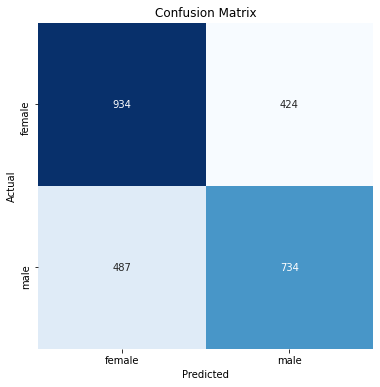

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ['female', 'male'])
plt.yticks(np.arange(2) + 0.5, ['female', 'male'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n\n", clr)

Classification Report:

               precision    recall  f1-score   support

      female       0.66      0.69      0.67      1358
        male       0.63      0.60      0.62      1221

    accuracy                           0.65      2579
   macro avg       0.65      0.64      0.64      2579
weighted avg       0.65      0.65      0.65      2579



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=018075c4-cccb-4808-bac8-50a3988dbc16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>